<a href="https://colab.research.google.com/github/Yoshiki0418/-Generation-AI/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F

In [3]:
# データの用意
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.06MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



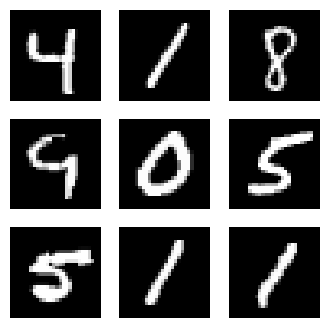

In [4]:
# 入力画像を描画してみる
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

### ハイパーパラメータ

画像の幅と高さが28x28ピクセルであるので、入力層には784のニューロンが必要になる。
また、出力が入力のようになることを再現するように学習するので、出力のニューロン数は入力層と一致させる。<br>

潜在変数とラベルの関係を２次元で可視化するため、まずは潜在変数の数を2とする。

In [5]:
# ハイパーパラメータの設定
image_size = 28
n_z = 2  # 潜在変数の数

a = 0.01
epochs = 100
batch_size = 32
mid_dim = 196

In [6]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)

### モデルの構築

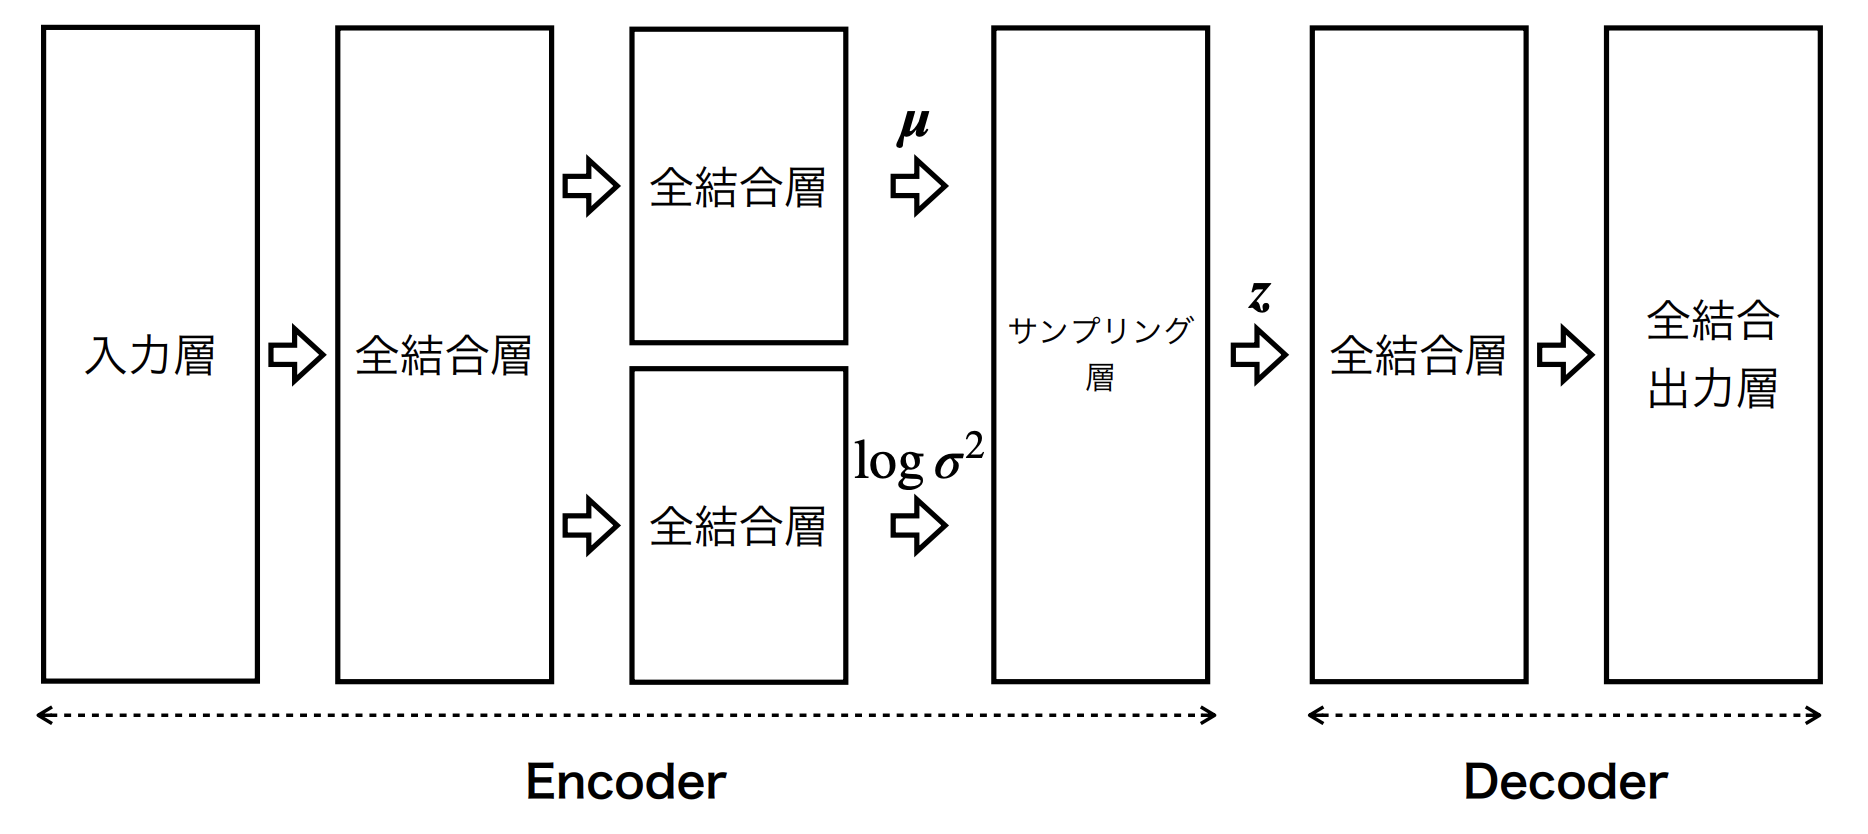

### 潜在変数

初期の潜在変数生成方法
VAEの設計上、エンコーダの役割は、入力データを潜在空間にマッピングし、その潜在空間に従う**正規分布（平均
𝜇
μ、分散
𝜎
2
 ）**を学習することです。初期の方法では、単純に次のように潜在変数
𝑧
 を生成していました。

𝑧
∼
𝑁
(
𝜇
,
𝜎
2
)
つまり、潜在変数
𝑧
を生成する際に、「平均
𝜇 と分散
𝜎
2
  の正規分布」から直接サンプリングしていました。しかし、この方法ではサンプリングのランダム性がエンコーダのパラメータ（すなわち、𝜇と 𝜎を求める層のパラメータ）に依存しているため、エンコーダのパラメータに対して勾配を計算することができませんでした。

#### リパラメータ化トリックによる解決策
この問題を解決するために、リパラメータ化トリックが導入されました。リパラメータ化トリックでは、サンプリング過程を次のように分解します：

𝑧
=
𝜇
+
𝜎
×
𝜖
ここで、
𝜖
∼
𝑁
(
0
,
1
)
は平均0、分散1の標準正規分布からサンプリングされる独立したノイズです。この形式により、サンプリングのランダム性がパラメータ
𝜇や
𝜎から独立します。この結果、潜在変数
𝑧はエンコーダのパラメータ
𝜇と
𝜎の関数として表現できるため、エンコーダのパラメータに対する勾配計算が可能になります。

In [7]:
class VAE(nn.Module):
  def __init__(self, image_size: tuple[int | int], mid_dim: int, n_z: int) -> None:
    super().__init__()
    self.in_dim = self.size_checker(image_size)

    self.encoder_mid = nn.Linear(self.in_dim, mid_dim)
    self.encoder_avg = nn.Linear(mid_dim, n_z) # 平均を求める層
    self.encoder_stand = nn.Linear(mid_dim, n_z) # 標準偏差を求める層

    self.decoder_mid = nn.Linear(n_z, mid_dim)
    self.decoder_out = nn.Linear(mid_dim, self.in_dim)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.encoder(x) # z -> サンプリングされた値
    out = self.decoder(z)
    return out

  def encoder(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, self.in_dim)

    x = self.relu(self.encoder_mid(x))
    self.avg = self.encoder_avg(x)
    self.stand = self.encoder_stand(x)

    std = torch.exp(0.5*self.stand)
    eps = torch.randn_like(std)
    return self.avg + std * eps # 潜在変数(reparameterization trick)

  def decoder(self, z: torch.Tensor) -> torch.Tensor:
    x = self.relu(self.decoder_mid(z))
    x = self.sigmoid(self.decoder_out(x))
    return x

  def size_checker(self, image_size: tuple[int] | int) -> int:
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

  def loss(self, x: torch.Tensor, x_pred: torch.Tensor) -> tuple[torch.Tensor]:
    """
    Args:
      x: 真の値（入力と出力が一致するように学習するためxを受け取る）
      x_pred: 予測値
    """
    x = x.view(-1, self.in_dim)

    rec_loss = F.binary_cross_entropy(x_pred, x, reduction="sum")
    reg_loss = 0.5 * torch.sum(self.avg**2 + torch.exp(self.stand) - self.stand - 1)
    return (rec_loss, reg_loss)

vae = VAE(image_size, mid_dim, n_z)
vae.cuda()
print(vae)


VAE(
  (encoder_mid): Linear(in_features=784, out_features=196, bias=True)
  (encoder_avg): Linear(in_features=196, out_features=2, bias=True)
  (encoder_stand): Linear(in_features=196, out_features=2, bias=True)
  (decoder_mid): Linear(in_features=2, out_features=196, bias=True)
  (decoder_out): Linear(in_features=196, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


### 学習

In [8]:
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x, _) in enumerate(train_loader):
    x = x.cuda()
    y_pred = vae(x)
    lrec, lreg = vae.loss(x, y_pred)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total /= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)

  if i%10 == 0:
      print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 5586.979307552083 Loss_Reg: 175.45848816566468 Loss_Total: 5762.437796614583
Epoch: 10 Loss_Rec: 4685.989928776042 Loss_Reg: 189.21022931315105 Loss_Total: 4875.200159244791
Epoch: 20 Loss_Rec: 4578.079921744792 Loss_Reg: 196.4412062906901 Loss_Total: 4774.521128125
Epoch: 30 Loss_Rec: 4519.041873697916 Loss_Reg: 200.55254520670573 Loss_Total: 4719.594420182291
Epoch: 40 Loss_Rec: 4481.5194375 Loss_Reg: 203.13257538248698 Loss_Total: 4684.652013020834
Epoch: 50 Loss_Rec: 4456.565357942708 Loss_Reg: 204.8617273030599 Loss_Total: 4661.427083203125
Epoch: 60 Loss_Rec: 4437.378617057292 Loss_Reg: 206.29431256510418 Loss_Total: 4643.672930989584
Epoch: 70 Loss_Rec: 4419.886109765625 Loss_Reg: 207.383322273763 Loss_Total: 4627.26943046875
Epoch: 80 Loss_Rec: 4408.152068359375 Loss_Reg: 207.99387237141926 Loss_Total: 4616.145943098958
Epoch: 90 Loss_Rec: 4397.0929203125 Loss_Reg: 209.36061486002603 Loss_Total: 4606.4535364583335


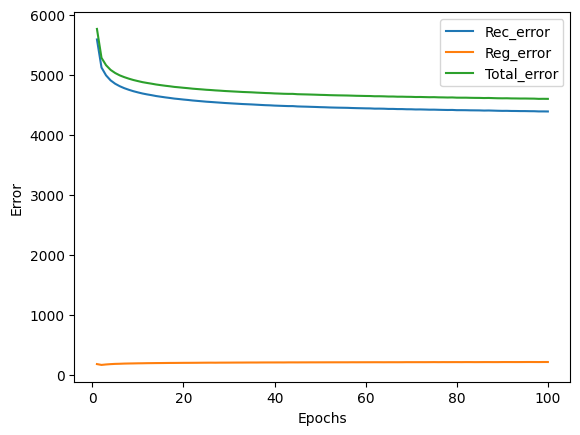

In [9]:
plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 潜在変数の可視化
潜在変数を平面にプロットすることで2次元の潜在変数がどのように表現できるのかを可視化する。

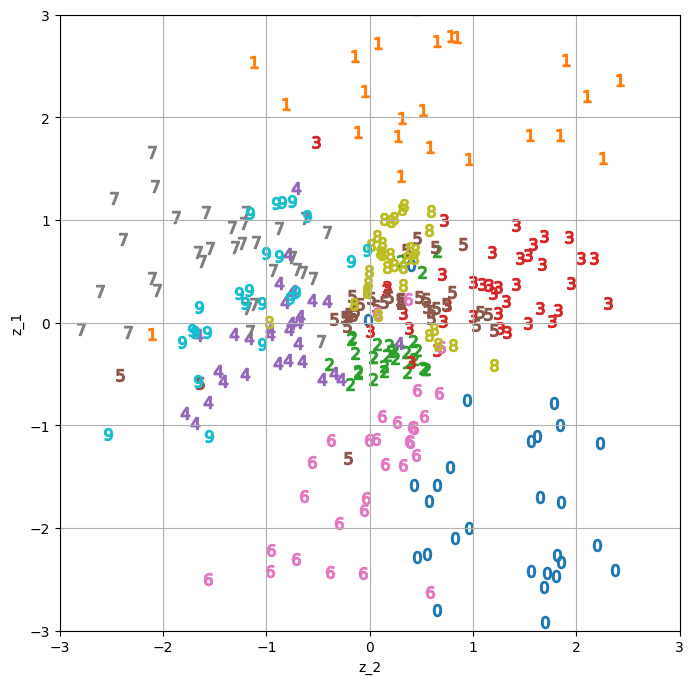

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 評価モード
vae.eval()

# 潜在変数とラベルの蓄積用リスト
z_list = []
t_list = []

# サンプルを複数回取得して蓄積
num_batches = 10  # 必要なバッチ数を指定
for _ in range(num_batches):
    x, t = next(iter(train_loader))  # 1バッチ取得
    x = x.cuda()

    # 潜在変数を計算
    z = vae.encoder(x)
    z = z.cpu().detach().numpy()
    t = t.cpu().detach().numpy()  # ラベルをnumpyに変換

    # 潜在変数とラベルを蓄積
    z_list.append(z)
    t_list.append(t)

# 蓄積したデータを配列に変換
z_all = np.concatenate(z_list, axis=0)
t_all = np.concatenate(t_list, axis=0)

# 潜在変数を平面にプロット
plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z_all[t_all == i]
    z_1 = zt[:, 0]  # y軸
    z_2 = zt[:, 1]  # x軸
    marker = "$" + str(i) + "$"  # 数値をマーカーに
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()
plt.show()


### 画像の生成

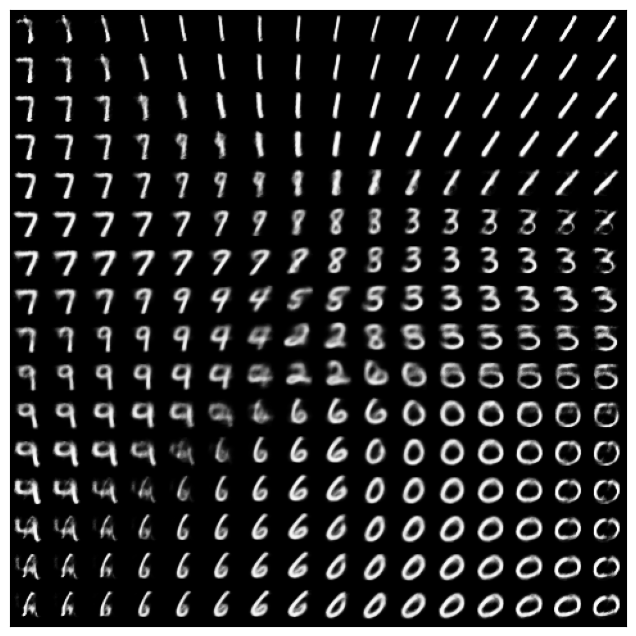

In [11]:
# 画像の設定
n_img = 16  # 画像を16x16並べる
img_size_spaced = image_size + 2
matrix_image = np.zeros((img_size_spaced*n_img, img_size_spaced*n_img))  # 全体の画像

# 潜在変数
z_1 = np.linspace(3, -3, n_img)  # 行
z_2 = np.linspace(-3, 3, n_img)  # 列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        z = torch.tensor([[z1, z2]], dtype=torch.float)
        z = z.cuda()
        y = vae.decoder(z)  # Decoder
        y = y.cpu().detach().numpy()
        image = y.reshape(image_size, image_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+image_size, left : left+image_size] = image

plt.figure(figsize=(8, 8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.show()

### 潜在変数を3次元で表現する

In [12]:
# 潜在変数の数を更新
n_z = 3

In [13]:
vae = VAE(image_size, mid_dim, n_z)
vae.cuda()
print(vae)

VAE(
  (encoder_mid): Linear(in_features=784, out_features=196, bias=True)
  (encoder_avg): Linear(in_features=196, out_features=3, bias=True)
  (encoder_stand): Linear(in_features=196, out_features=3, bias=True)
  (decoder_mid): Linear(in_features=3, out_features=196, bias=True)
  (decoder_out): Linear(in_features=196, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [14]:
# 再学習
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x, _) in enumerate(train_loader):
    x = x.cuda()
    y_pred = vae(x)
    lrec, lreg = vae.loss(x, y_pred)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total /= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)

  if i%10 == 0:
      print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 5178.2229546875 Loss_Reg: 235.62479585994086 Loss_Total: 5413.847753125
Epoch: 10 Loss_Rec: 4241.5034669270835 Loss_Reg: 251.85994844563803 Loss_Total: 4493.363415234375
Epoch: 20 Loss_Rec: 4147.514316927083 Loss_Reg: 258.9923337076823 Loss_Total: 4406.50665234375
Epoch: 30 Loss_Rec: 4101.214876953125 Loss_Reg: 262.84038641764323 Loss_Total: 4364.05526328125
Epoch: 40 Loss_Rec: 4069.3801141927083 Loss_Reg: 265.3908045410156 Loss_Total: 4334.770922135417
Epoch: 50 Loss_Rec: 4047.5854756510416 Loss_Reg: 267.68996577148437 Loss_Total: 4315.275449739584
Epoch: 60 Loss_Rec: 4028.6811481770833 Loss_Reg: 269.4851993896484 Loss_Total: 4298.166347526042
Epoch: 70 Loss_Rec: 4014.201099609375 Loss_Reg: 270.07394707845054 Loss_Total: 4284.275042838542
Epoch: 80 Loss_Rec: 4002.3693134114583 Loss_Reg: 270.7327429117839 Loss_Total: 4273.102054947916
Epoch: 90 Loss_Rec: 3992.3853006510417 Loss_Reg: 272.34506100260415 Loss_Total: 4264.730365364583


In [15]:
# Google Colabでインタラクティブな3Dプロットを行うための設定
!pip install ipympl  # 初回のみ実行

%matplotlib widget
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.0 MB/s eta 0:00:00


In [16]:
# plotlyをインストール（初回のみ）
!pip install plotly

import numpy as np
import torch
import plotly.graph_objects as go

# 評価モード
vae.eval()

# 潜在変数とラベルの蓄積用リスト
z_list = []
t_list = []

# サンプルを複数回取得して蓄積
num_batches = 10  # 必要なバッチ数を指定
for _ in range(num_batches):
    x, t = next(iter(train_loader))  # 1バッチ取得
    x = x.cuda()

    # 潜在変数を計算
    z = vae.encoder(x)
    z = z.cpu().detach().numpy()
    t = t.cpu().detach().numpy()  # ラベルをnumpyに変換

    # 潜在変数とラベルを蓄積
    z_list.append(z)
    t_list.append(t)

# 蓄積したデータを配列に変換
z_all = np.concatenate(z_list, axis=0)
t_all = np.concatenate(t_list, axis=0)

# Plotlyで3Dプロット
fig = go.Figure()

# 各クラスごとにプロット
for i in range(10):
    zt = z_all[t_all == i]
    z_1 = zt[:, 0]  # x軸
    z_2 = zt[:, 1]  # y軸
    z_3 = zt[:, 2]  # z軸

    fig.add_trace(go.Scatter3d(
        x=z_1,
        y=z_2,
        z=z_3,
        mode='markers',
        marker=dict(size=5),
        name=f"Class {i}"
    ))

# 軸ラベルの設定
fig.update_layout(scene=dict(
                    xaxis_title="z_1",
                    yaxis_title="z_2",
                    zaxis_title="z_3"),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# プロットを表示
fig.show()


Generated tensor shape: torch.Size([1, 784])
Generated tensor min: tensor(0., device='cuda:0')
Generated tensor max: tensor(0.8595, device='cuda:0')
Image shape after reshape: (28, 28)


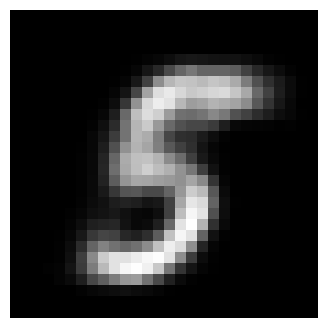

In [17]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

# ランダムな潜在変数を指定
z_random = torch.randn((1, 3), dtype=torch.float32)  # 3次元潜在変数
z_random = z_random.cuda()  # GPUへ転送

# デコーダーで画像を生成
vae.eval()  # 評価モード
with torch.no_grad():
    y = vae.decoder(z_random)

# 出力情報の確認
print("Generated tensor shape:", y.shape)  # yの形状
print("Generated tensor min:", y.min())
print("Generated tensor max:", y.max())

# リシェイプして表示
image = y.cpu().detach().numpy().reshape((28, 28))
print("Image shape after reshape:", image.shape)  # 変換後の形状

# 描画を確認
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")  # グレースケールマップ
plt.axis("off")
plt.show()


### FashionMNISTデータをVAEで生成する

In [21]:
# FashionMNISTデータでVAEを試す
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

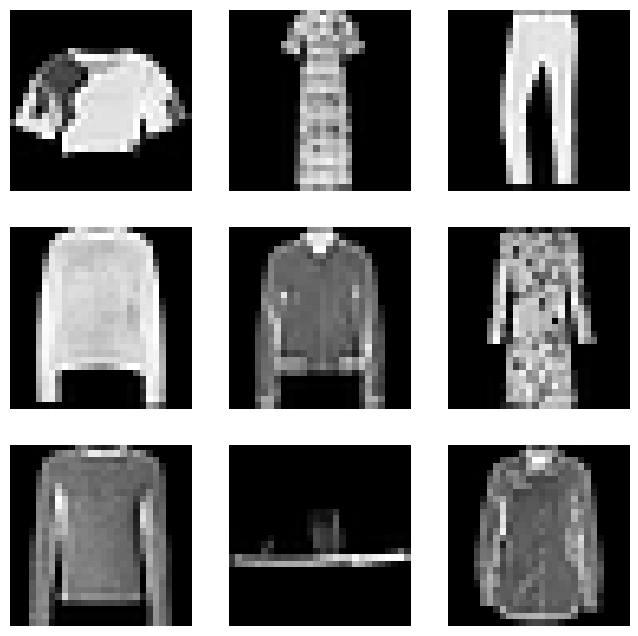

In [22]:
# 入力画像を描画する
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, rows*cols + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [37]:
# ハイパーパラメータ
image_size = 28
n_z = 12  # 潜在変数の数

a = 0.01
epochs = 100
batch_size = 128
mid_dim = 128

In [38]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)

In [39]:
class VAE(nn.Module):
  def __init__(self, image_size: tuple[int | int], mid_dim: int, n_z: int) -> None:
    super().__init__()
    self.in_dim = self.size_checker(image_size)

    self.encoder_mid = nn.Linear(self.in_dim, 32)
    self.encoder_mid2 = nn.Linear(32, 64)
    self.encoder_mid3 = nn.Linear(64, mid_dim)
    self.encoder_avg = nn.Linear(mid_dim, n_z) # 平均を求める層
    self.encoder_stand = nn.Linear(mid_dim, n_z) # 標準偏差を求める層

    self.decoder_mid = nn.Linear(n_z, mid_dim)
    self.decoder_out = nn.Linear(mid_dim, self.in_dim)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.encoder(x) # z -> サンプリングされた値
    out = self.decoder(z)
    return out

  def encoder(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, self.in_dim)

    x = self.relu(self.encoder_mid(x))
    x = self.relu(self.encoder_mid2(x))
    x = self.relu(self.encoder_mid3(x))
    self.avg = self.encoder_avg(x)
    self.stand = self.encoder_stand(x)

    std = torch.exp(0.5*self.stand)
    eps = torch.randn_like(std)
    return self.avg + std * eps # 潜在変数(reparameterization trick)

  def decoder(self, z: torch.Tensor) -> torch.Tensor:
    x = self.relu(self.decoder_mid(z))
    x = self.sigmoid(self.decoder_out(x))
    return x

  def size_checker(self, image_size: tuple[int] | int) -> int:
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

  def loss(self, x: torch.Tensor, x_pred: torch.Tensor) -> tuple[torch.Tensor]:
    """
    Args:
      x: 真の値（入力と出力が一致するように学習するためxを受け取る）
      x_pred: 予測値
    """
    x = x.view(-1, self.in_dim)

    rec_loss = F.binary_cross_entropy(x_pred, x, reduction="sum")
    reg_loss = 0.5 * torch.sum(self.avg**2 + torch.exp(self.stand) - self.stand - 1)
    return (rec_loss, reg_loss)

vae = VAE(image_size, mid_dim, n_z)
vae.cuda()

VAE(
  (encoder_mid): Linear(in_features=784, out_features=32, bias=True)
  (encoder_mid2): Linear(in_features=32, out_features=64, bias=True)
  (encoder_mid3): Linear(in_features=64, out_features=128, bias=True)
  (encoder_avg): Linear(in_features=128, out_features=12, bias=True)
  (encoder_stand): Linear(in_features=128, out_features=12, bias=True)
  (decoder_mid): Linear(in_features=12, out_features=128, bias=True)
  (decoder_out): Linear(in_features=128, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [40]:
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x, _) in enumerate(train_loader):
    x = x.cuda()
    y_pred = vae(x)
    lrec, lreg = vae.loss(x, y_pred)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total /= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)

  if i%10 == 0:
      print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 38782.71711337287 Loss_Reg: 1432.3507858502078 Loss_Total: 40215.067917943765
Epoch: 10 Loss_Rec: 30038.527302105544 Loss_Reg: 1582.376041892241 Loss_Total: 31620.903347381398
Epoch: 20 Loss_Rec: 29648.279775786246 Loss_Reg: 1632.0273588461155 Loss_Total: 31280.30713619403
Epoch: 30 Loss_Rec: 29503.07341917644 Loss_Reg: 1643.5220975896189 Loss_Total: 31146.5955115605
Epoch: 40 Loss_Rec: 29431.186234008528 Loss_Reg: 1650.161327500333 Loss_Total: 31081.347543809967
Epoch: 50 Loss_Rec: 29379.253227445362 Loss_Reg: 1651.3108287559135 Loss_Total: 31030.564074160447
Epoch: 60 Loss_Rec: 29345.017515658317 Loss_Reg: 1652.880170940082 Loss_Total: 30997.897708722016
Epoch: 70 Loss_Rec: 29314.27736040778 Loss_Reg: 1651.9327499292044 Loss_Total: 30966.210112939767
Epoch: 80 Loss_Rec: 29291.733862773188 Loss_Reg: 1654.656977216318 Loss_Total: 30946.390845715618
Epoch: 90 Loss_Rec: 29271.96633045709 Loss_Reg: 1655.4055639075825 Loss_Total: 30927.371889159116


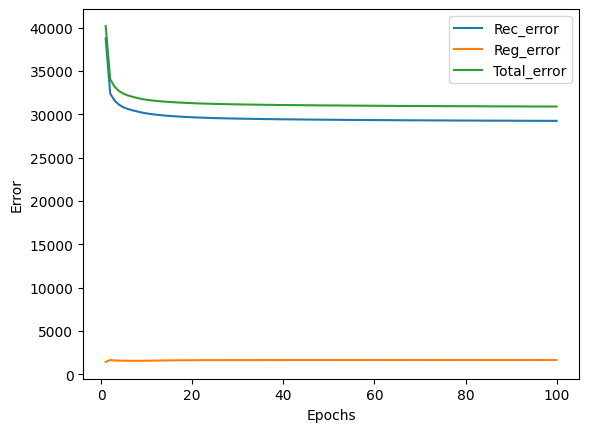

In [42]:
plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

Generated tensor shape: torch.Size([1, 784])
Generated tensor min: tensor(1.2426e-30, device='cuda:0')
Generated tensor max: tensor(0.9315, device='cuda:0')
Image shape after reshape: (28, 28)


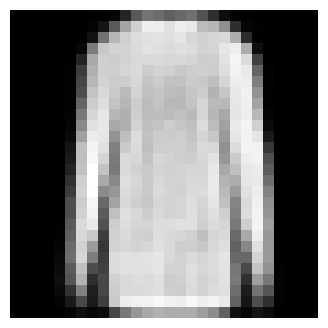

In [53]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

# ランダムな潜在変数を指定
z_random = torch.randn((1, n_z), dtype=torch.float32)  # 3次元潜在変数
z_random = z_random.cuda()  # GPUへ転送

# デコーダーで画像を生成
vae.eval()  # 評価モード
with torch.no_grad():
    y = vae.decoder(z_random)

# 出力情報の確認
print("Generated tensor shape:", y.shape)  # yの形状
print("Generated tensor min:", y.min())
print("Generated tensor max:", y.max())

# リシェイプして表示
image = y.cpu().detach().numpy().reshape((28, 28))
print("Image shape after reshape:", image.shape)  # 変換後の形状

# 描画を確認
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")  # グレースケールマップ
plt.axis("off")
plt.show()